In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision

from skimage import io
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

from mean_teacher import datasets, architectures
from mean_teacher.utils import *

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
to_image = transforms.ToPILImage()

%matplotlib inline

In [2]:
def load_weights(model_arch, pretrained_model_path, state_dict, cuda=True):
        # Load pretrained model
        pretrained_model = torch.load(f=pretrained_model_path, map_location="cuda" if cuda else "cpu")

        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in pretrained_model[state_dict].items():
            name = k[7:] # remove `module.`
            new_state_dict[name] = v

        # Load pre-trained weights in current model
        with torch.no_grad():
            model_arch.load_state_dict(new_state_dict, strict=True)

        # Debug loading
        #print('Parameters found in pretrained model:')
        pretrained_layers = new_state_dict.keys()
        #for l in pretrained_layers:
        #    print('\t' + l)
        #print('')

        for name, module in model_arch.state_dict().items():
            if name in pretrained_layers:
                assert torch.equal(new_state_dict[name].cpu(), module.cpu())
                #print('{} have been loaded correctly in current model.'.format(name))
            else:
                raise ValueError("state_dict() keys do not match")
                
        return model_arch


In [3]:
dataset_config = datasets.__dict__['sslMini']()

In [4]:
BATCH_SIZE = 32

evaldir = "/scratch/ijh216/ssl_mini/supervised/val"

eval_loader = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(evaldir, dataset_config['eval_transformation']),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=2,
                                              drop_last=False)


In [5]:
img_dir = eval_loader.dataset.imgs[0][0]
img = eval_loader.dataset[0][0].unsqueeze(0).to(device).detach()
img_class = eval_loader.dataset[0][1]

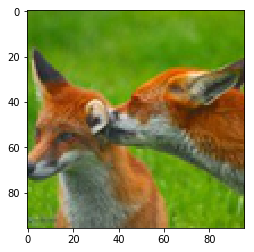

In [6]:
plt.imshow(io.imread(img_dir))

In [ ]:
sns.color_palette('pastel')

In [8]:
model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(0) 
model = architectures.__dict__['cifar_shakeshake26']().to(device)
model = load_weights(model, model_dir, state_dict="ema_state_dict", cuda=False)
labels = F.softmax(model(img)[0], dim=1)

for ckpt in tqdm(range(5, 325, 5)):

    model_dir = "/scratch/ijh216/ssl/ssl_shake_mini_augment/2019-05-06_18-04-18/10/transient/checkpoint.{}.ckpt".format(ckpt) 
    model = architectures.__dict__['cifar_shakeshake26']().to(device)
    model = load_weights(model, model_dir, state_dict="ema_state_dict", cuda=False)


    output = F.softmax(model(img)[0], dim=1)
    labels = torch.cat((labels, output))
    
labels_df = pd.DataFrame(labels.detach().numpy())
labels_df.index.name = "ckpt"

100%|██████████| 64/64 [03:18<00:00,  3.94s/it]


In [9]:
labels_df.head()

0         1         2         3         4         5         6    \
0  0.001021  0.000952  0.001025  0.000973  0.000978  0.001008  0.001048   
1  0.001271  0.000922  0.001179  0.001141  0.001240  0.000929  0.001165   
2  0.001430  0.000634  0.001108  0.001206  0.001086  0.000884  0.001164   
3  0.001572  0.000541  0.000991  0.001207  0.000997  0.000769  0.001045   
4  0.001627  0.000473  0.000882  0.001129  0.000969  0.000719  0.001115   

        7         8         9      ...          990       991       992  \
0  0.000954  0.000970  0.000964    ...     0.001016  0.000999  0.000959   
1  0.000828  0.001007  0.000969    ...     0.000609  0.000690  0.001305   
2  0.000680  0.000918  0.000845    ...     0.000566  0.000669  0.001440   
3  0.000542  0.000840  0.000658    ...     0.000511  0.000573  0.001486   
4  0.000502  0.000829  0.000669    ...     0.000548  0.000613  0.001374   

        993       994       995       996       997       998       999  
0  0.001031  0.001001  0.000999  0.001007  0.001003  0.000975  0.001000  
1  0.001287  0.001388  0.000671  0.001296  0.001288  0.000858  0.000822  
2  0.001497  0.001896  0.000702  0.001721  0.001678  0.000657  0.000683  
3  0.001791  0.002357  0.000679  0.001883  0.001908  0.000543  0.000622  
4  0.001936  0.002573  0.000676  0.002008  0.001756  0.000507  0.000570  

[5 rows x 1000 columns]

In [10]:
import seaborn as sns
sns.set_style("darkgrid")

In [14]:
labels_df.columns

RangeIndex(start=0, stop=1000, step=1)

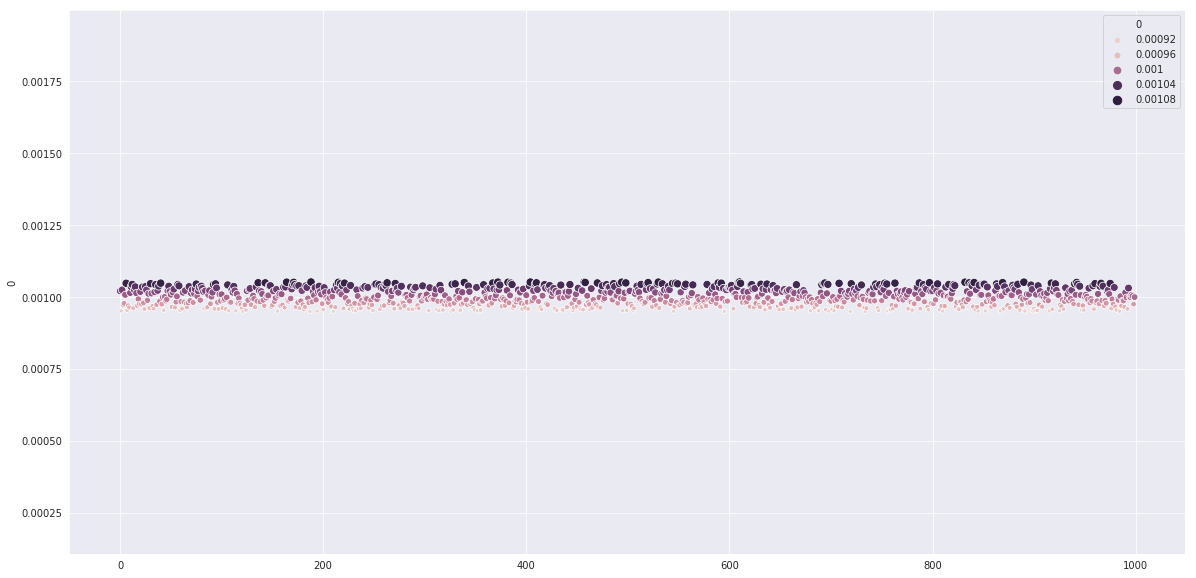

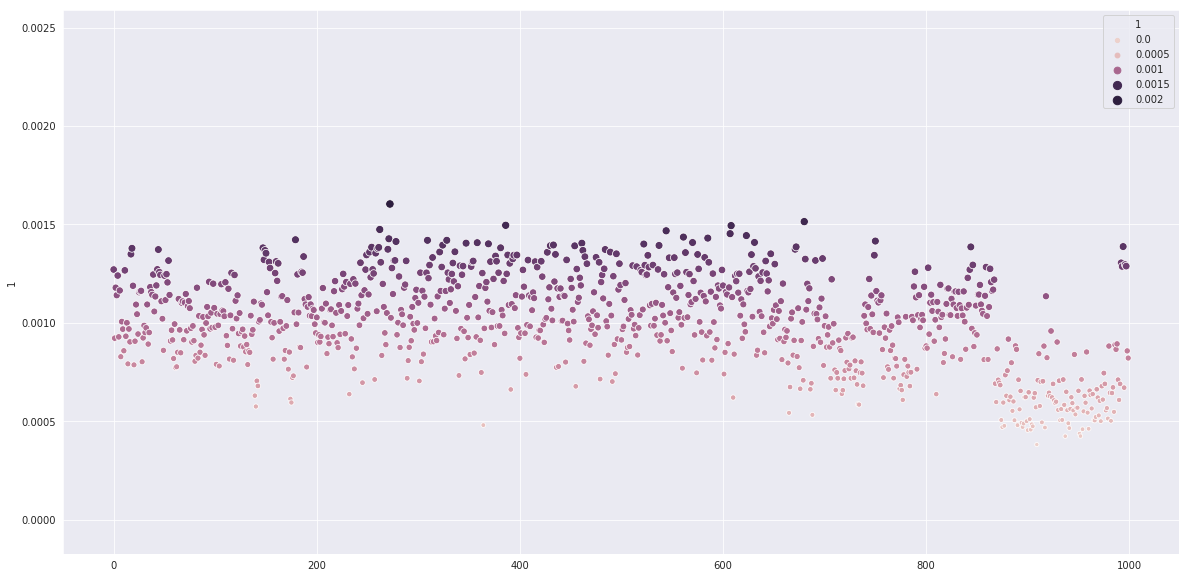

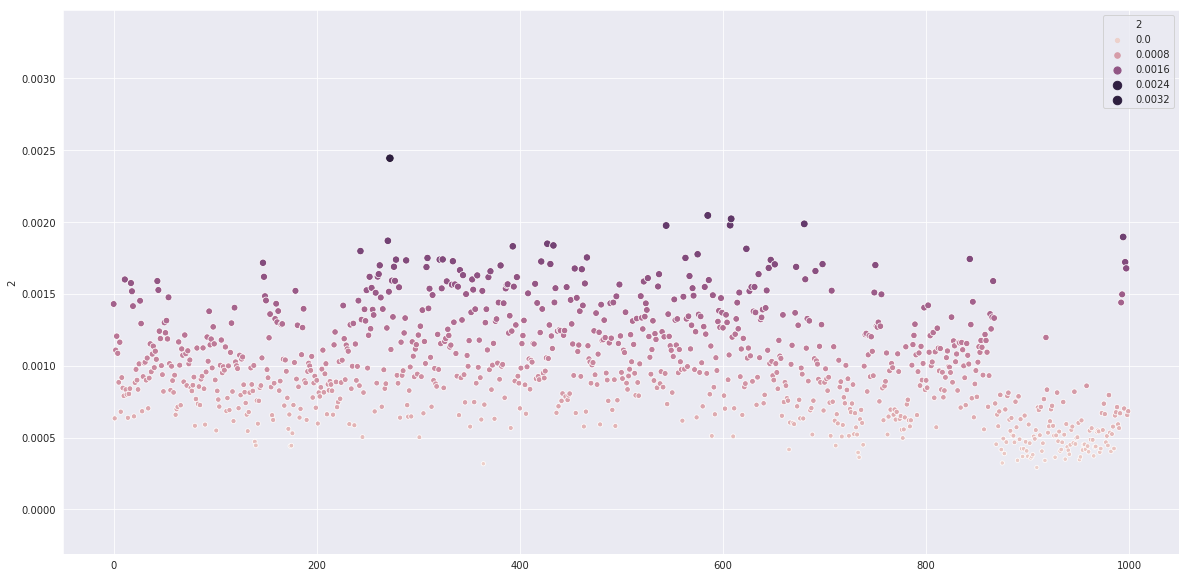

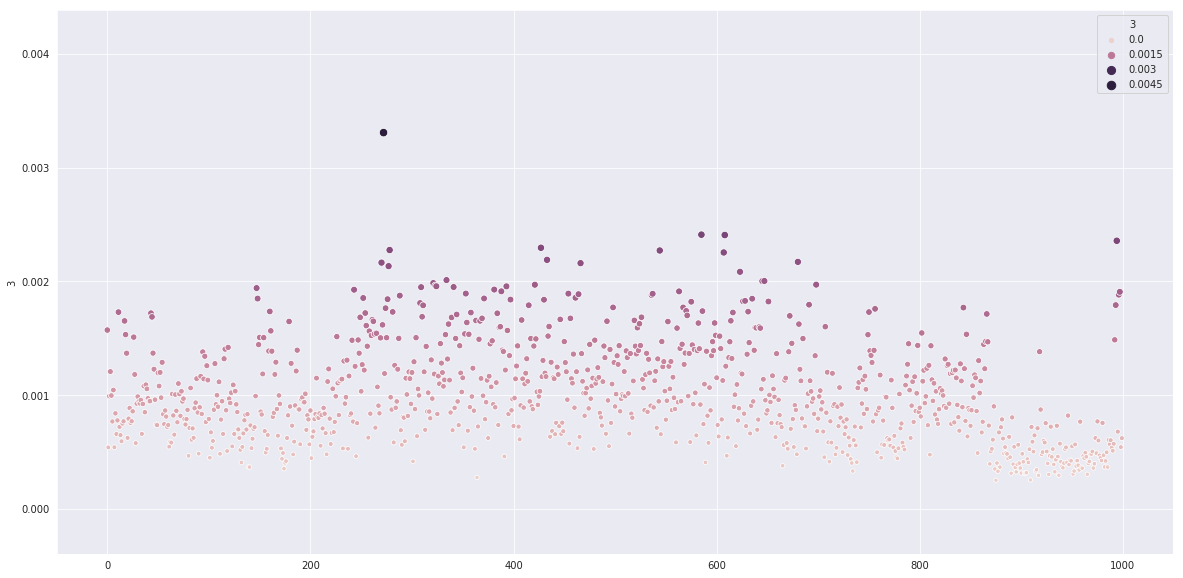

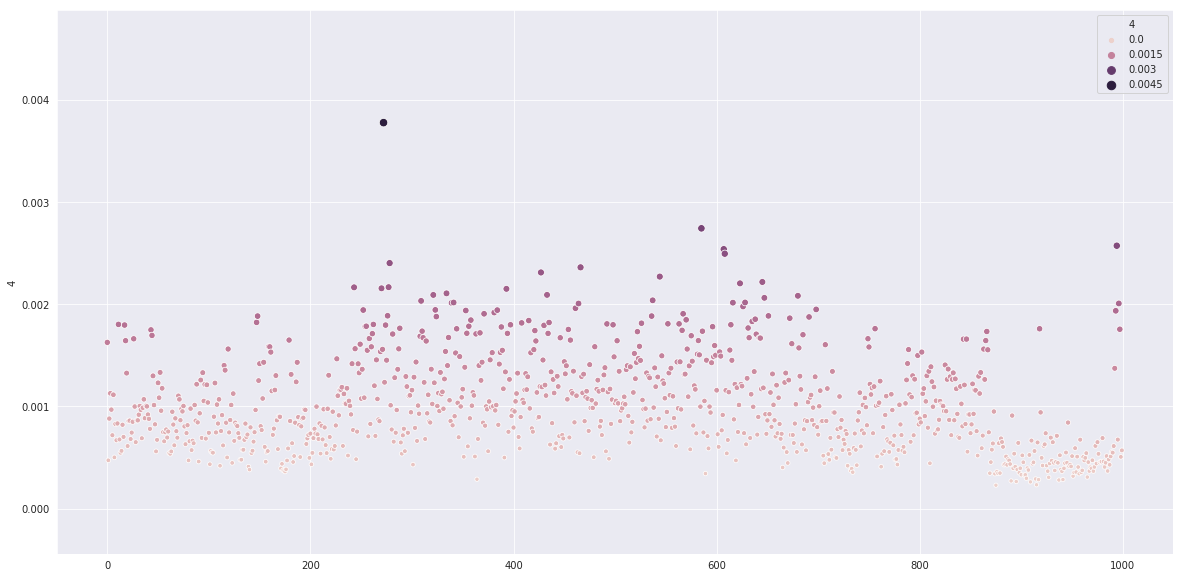

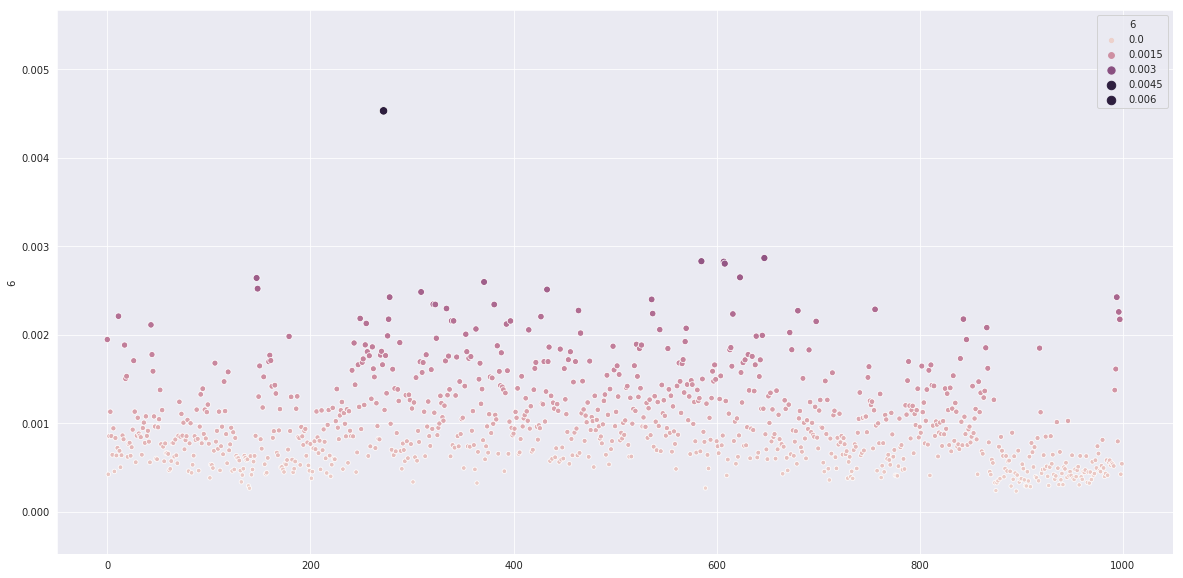

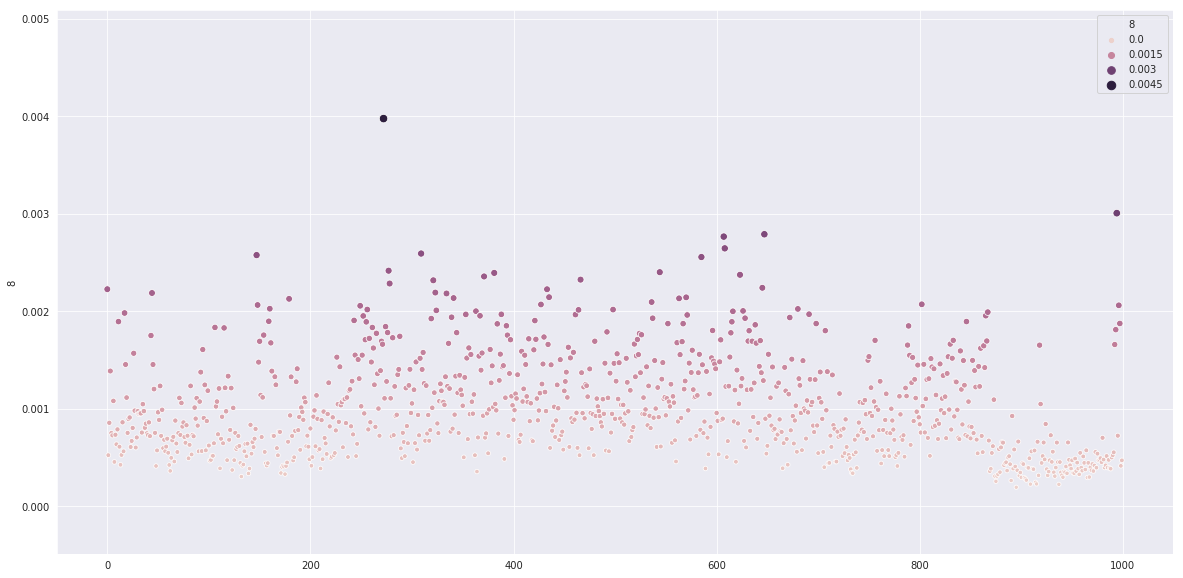

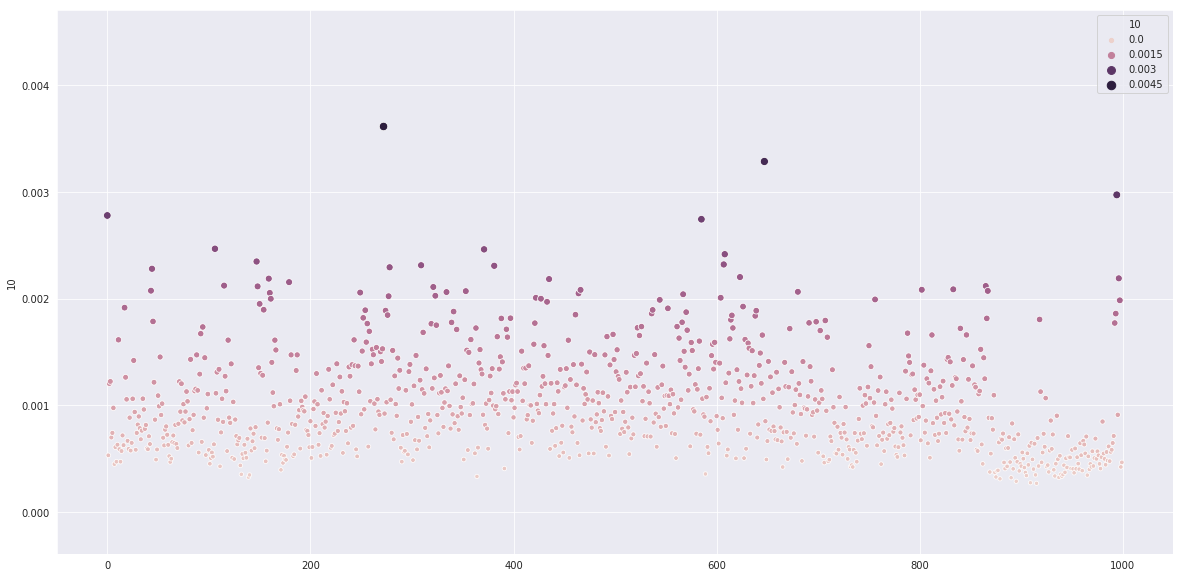

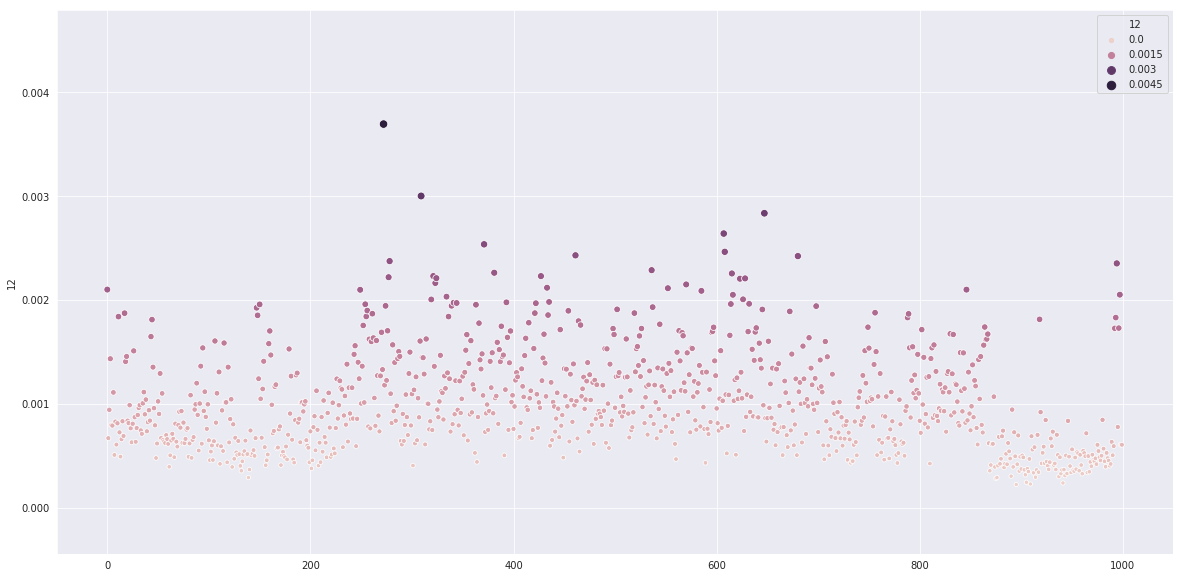

In [16]:
for i in range(0, 325, 25):
    
    labels_ckpt = labels_df.iloc[int(i/(25))]
    
    fig = plt.figure(figsize=(20,10))
    sns.scatterplot(x = labels_df.columns, 
                    y = labels_ckpt, 
                    hue = labels_ckpt, 
                    size = labels_ckpt)

In [38]:
labels_df_melt = pd.melt(labels_df.reset_index(), id_vars=['ckpt'], var_name='label', value_name='est')
labels_df_melt.head()

In [46]:
from mpl_toolkits.mplot3d import Axes3D

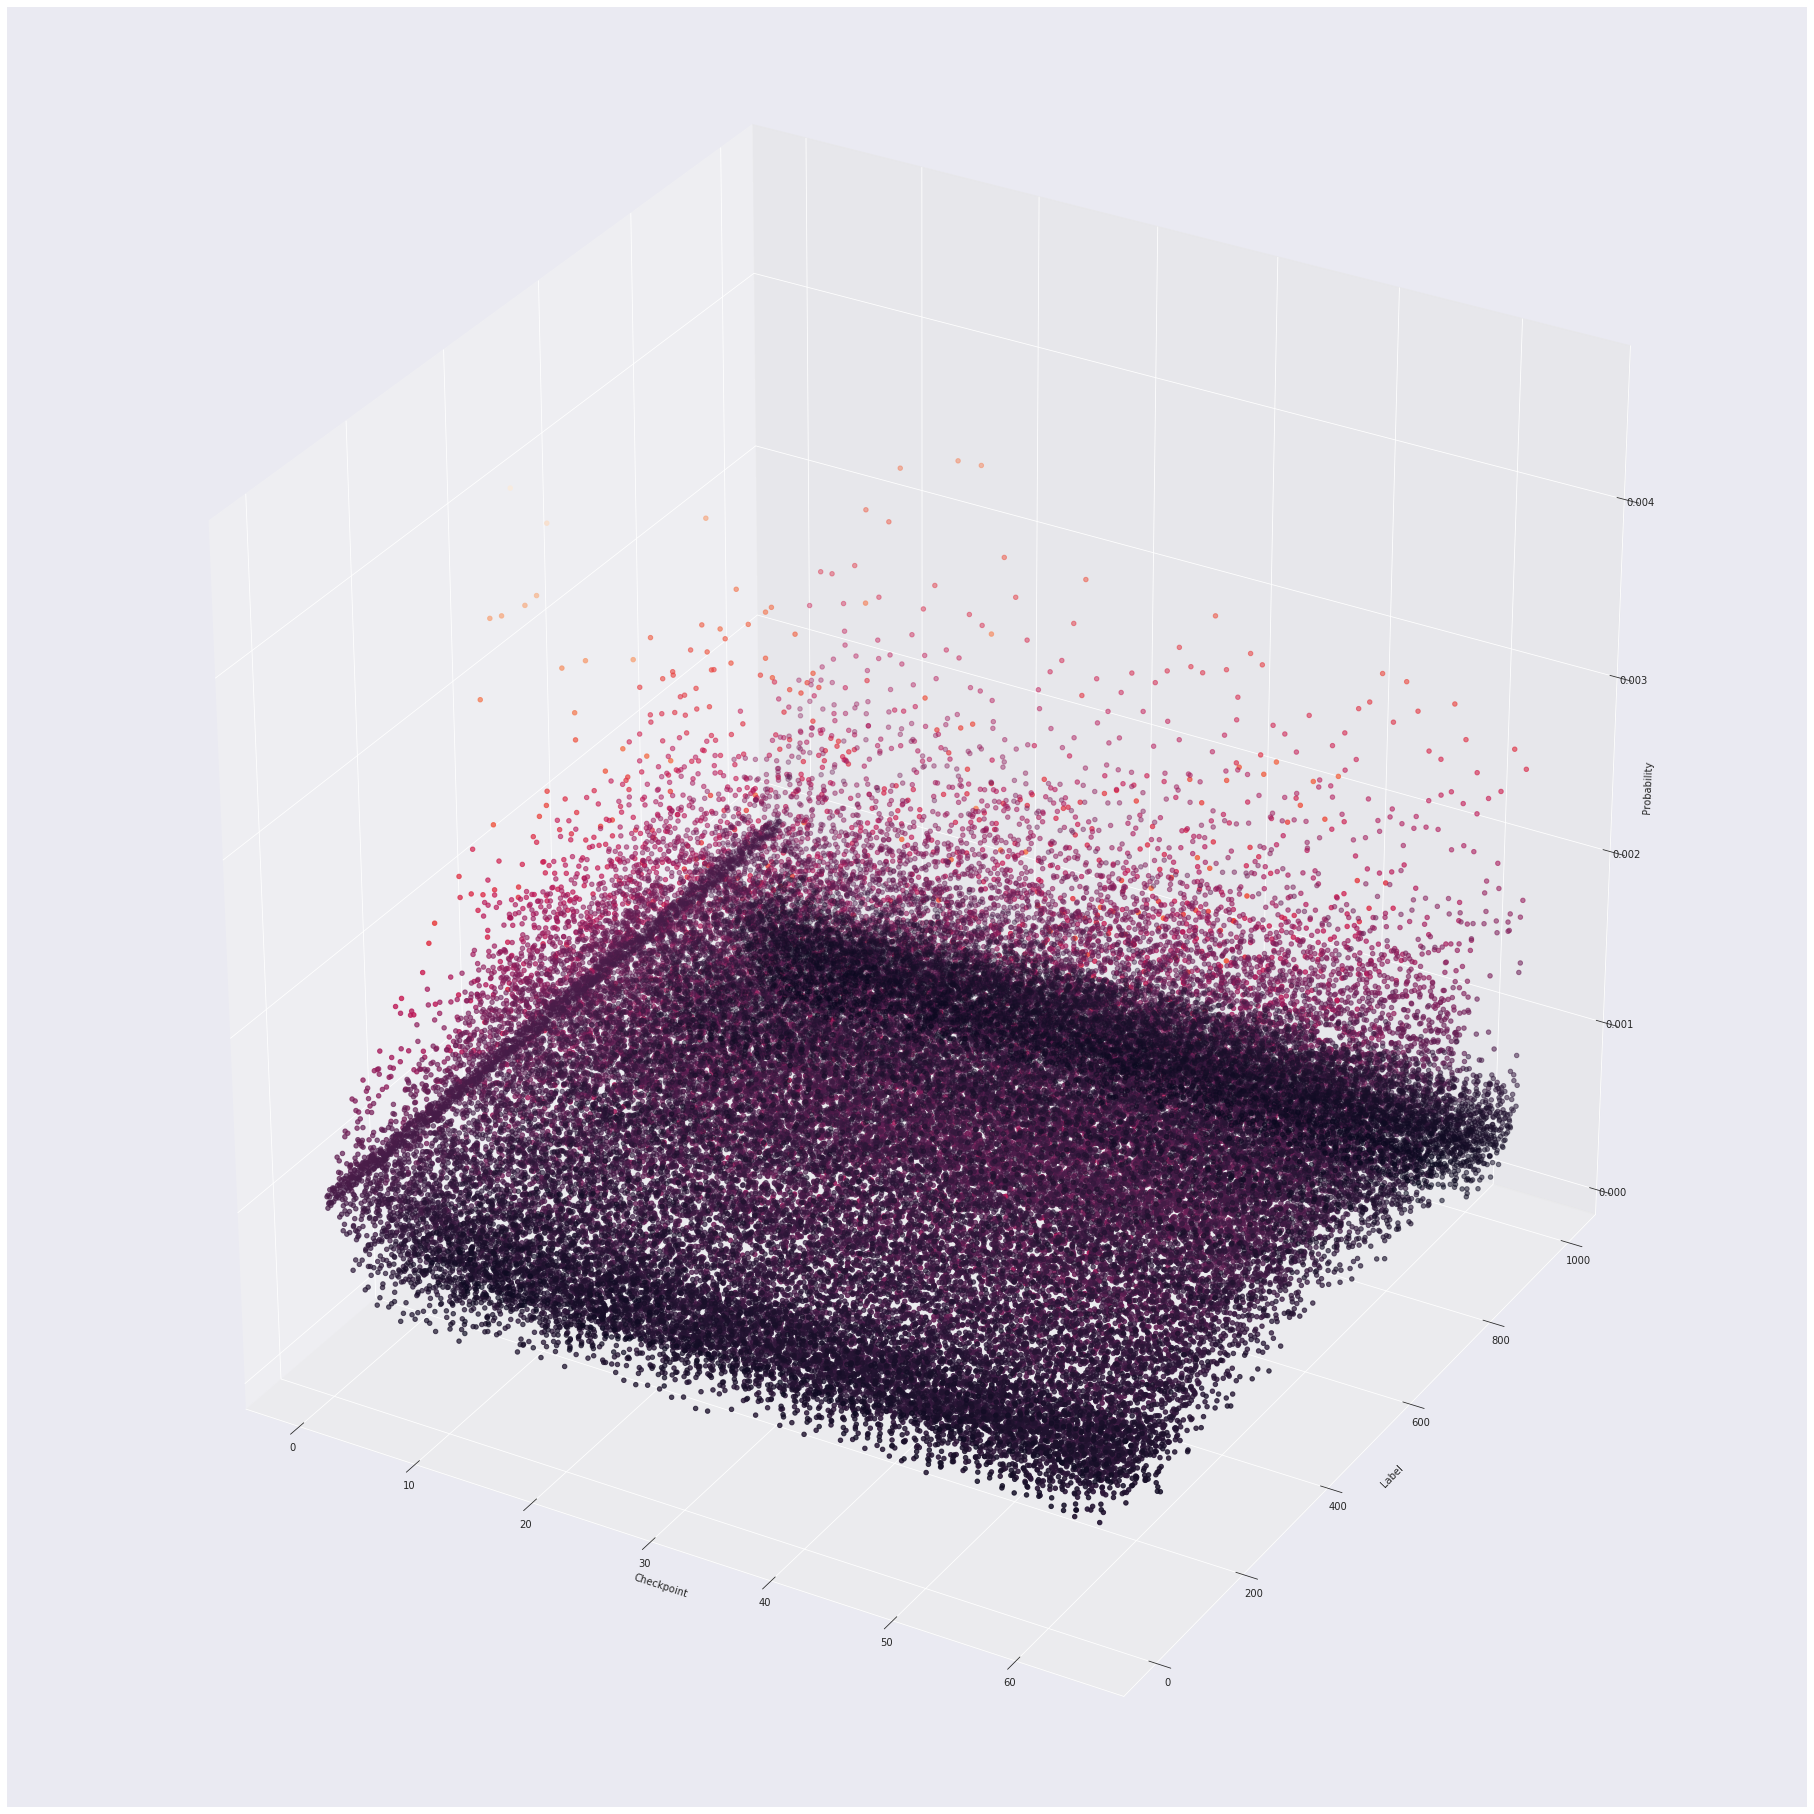

In [49]:
fig = plt.figure(figsize=(25,25))
ax = Axes3D(fig)

ax.scatter(labels_df_melt['ckpt'], 
           labels_df_melt['label'], 
           labels_df_melt['est'],
           c=labels_df_melt['est'],
          )

ax.set_xlabel('Checkpoint')
ax.set_ylabel('Label')
ax.set_zlabel('Probability')

plt.show()

In [51]:
sns.scatterplot(x = labels_df_melt['label'],  
                y = labels_df_melt['est'],  
                hue = labels_df_melt['ckpt']
               )

/share/apps/python3/3.6.3/intel/lib/python3.6/site-packages/scipy-1.0.0rc1-py3.6-linux-x86_64.egg/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


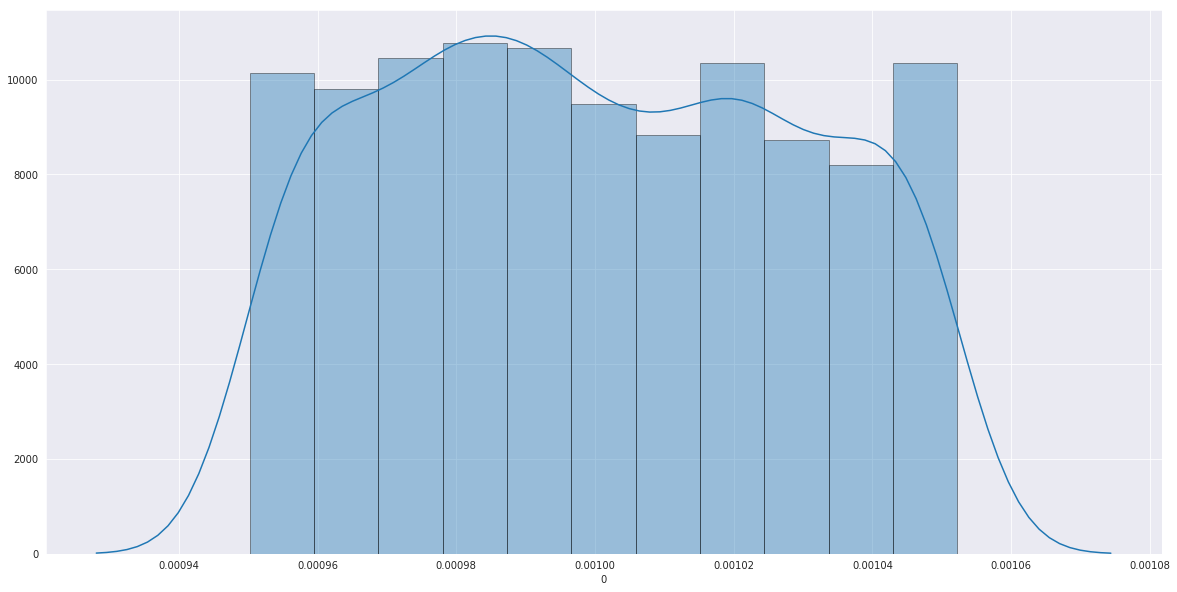

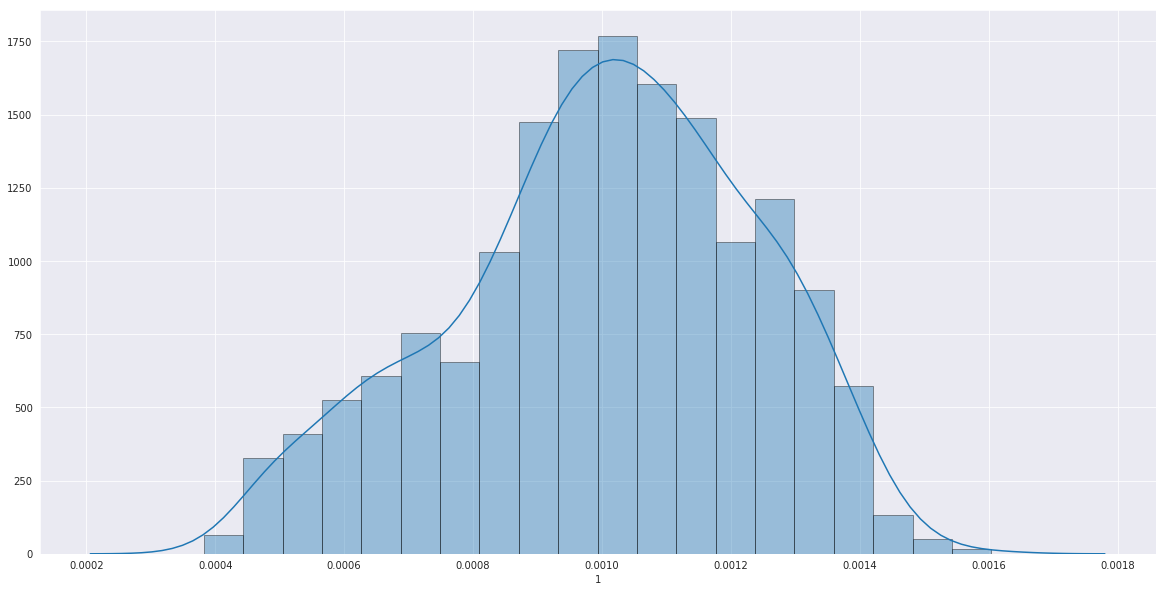

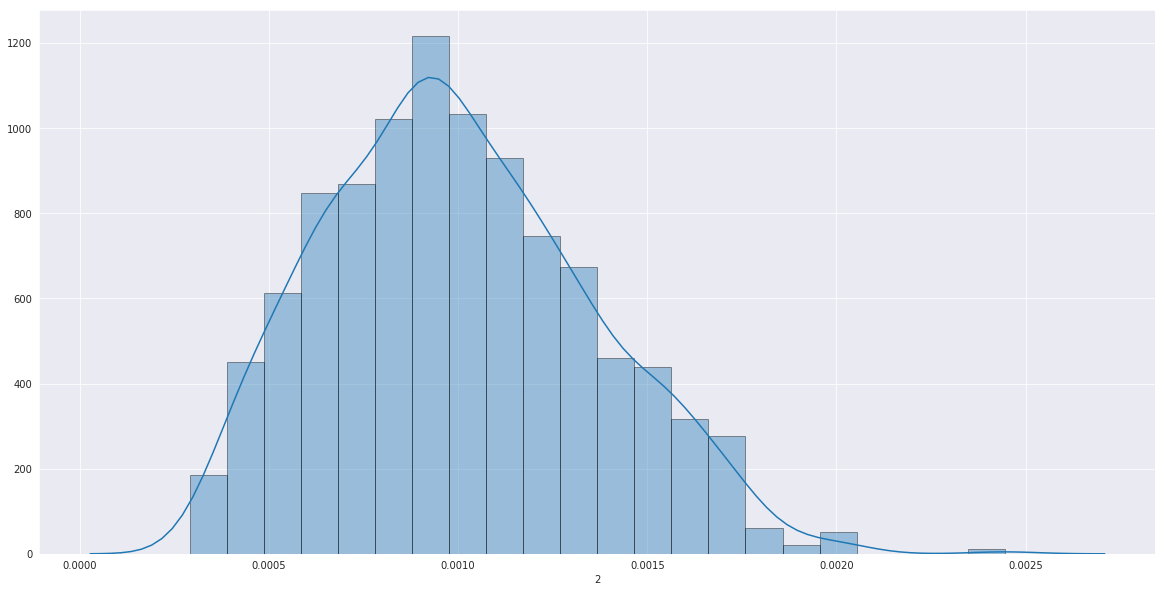

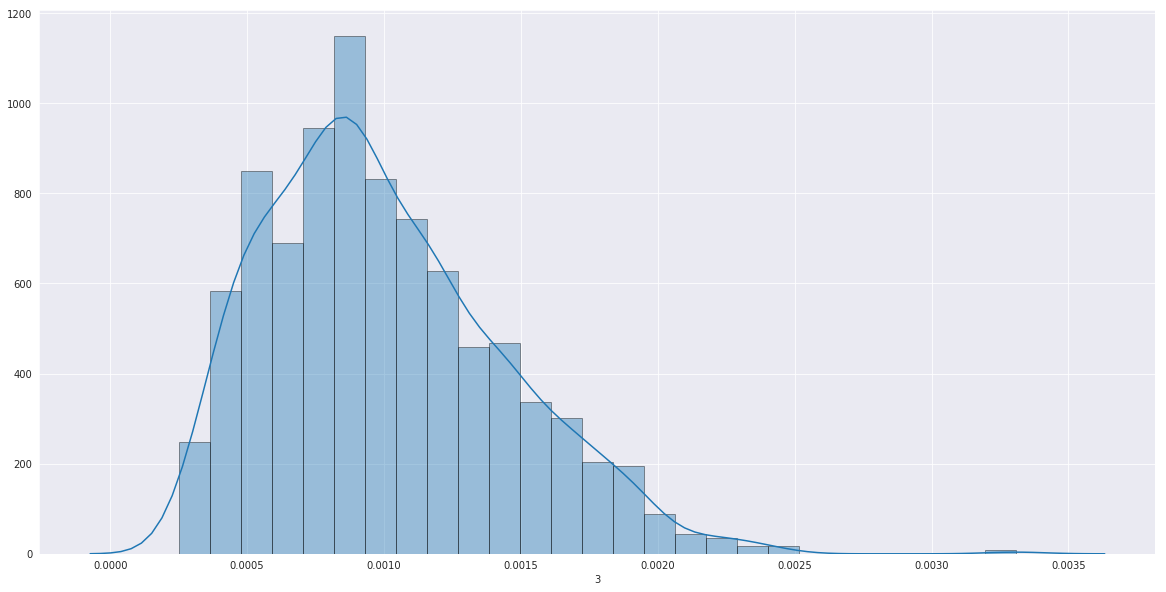

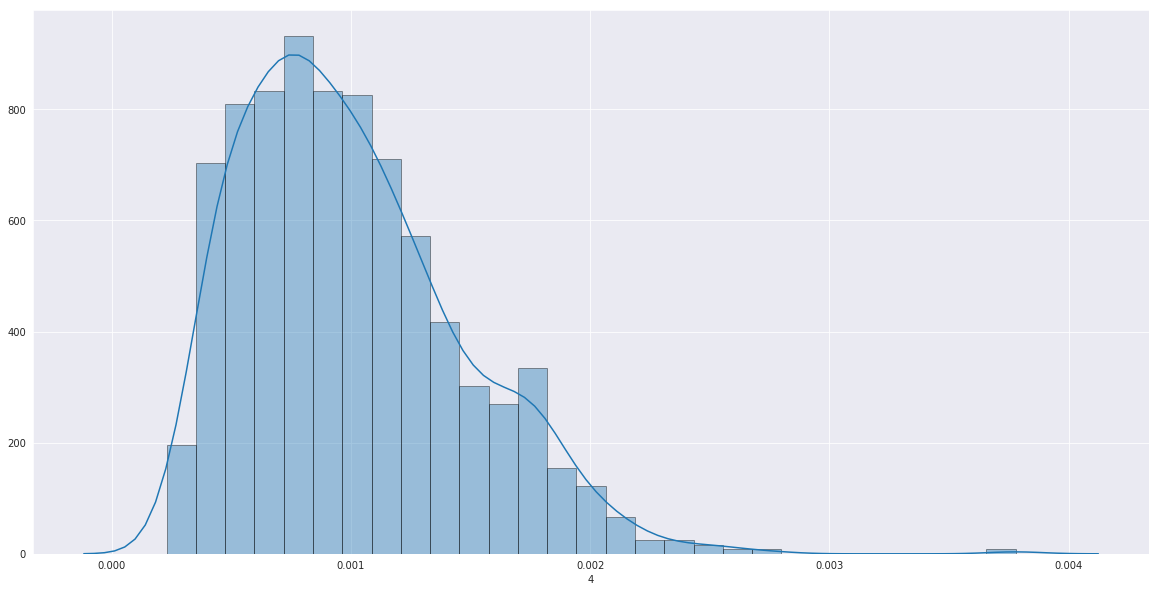

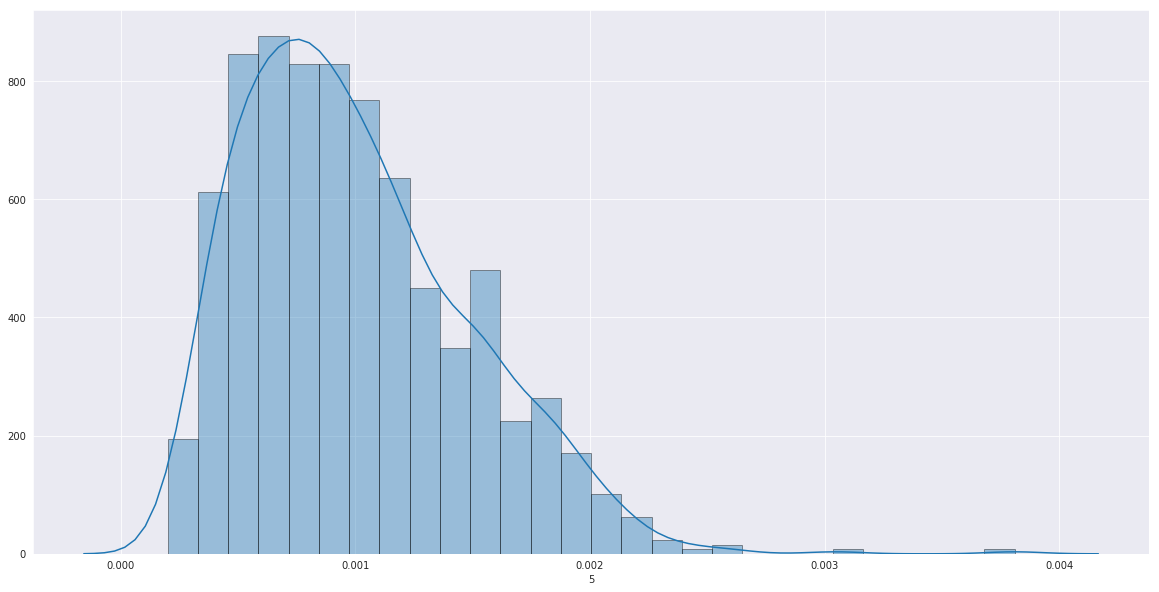

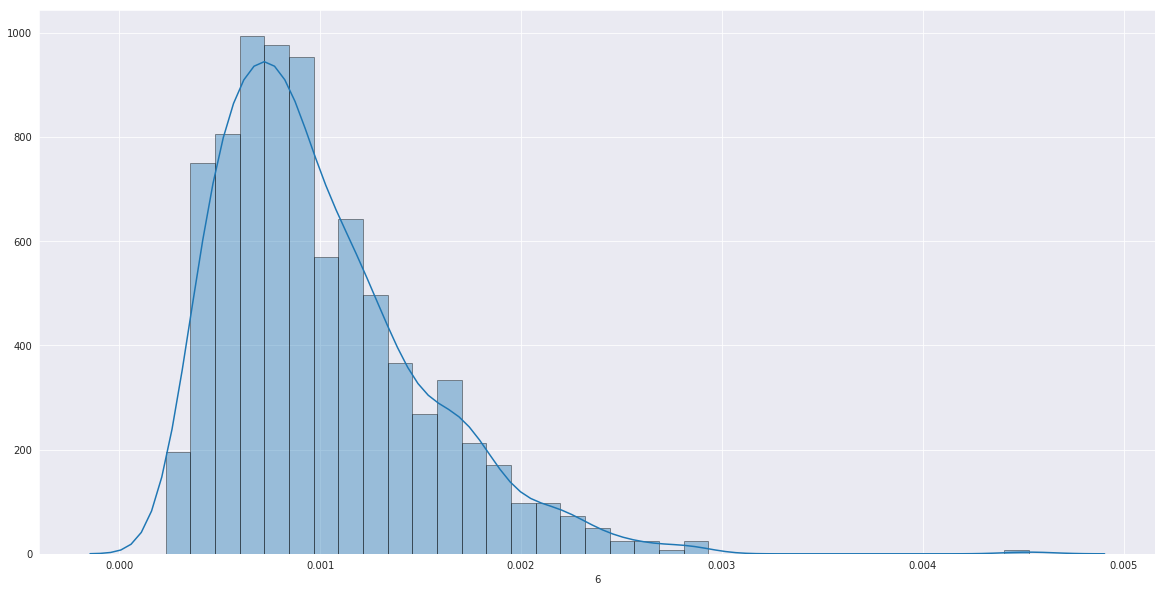

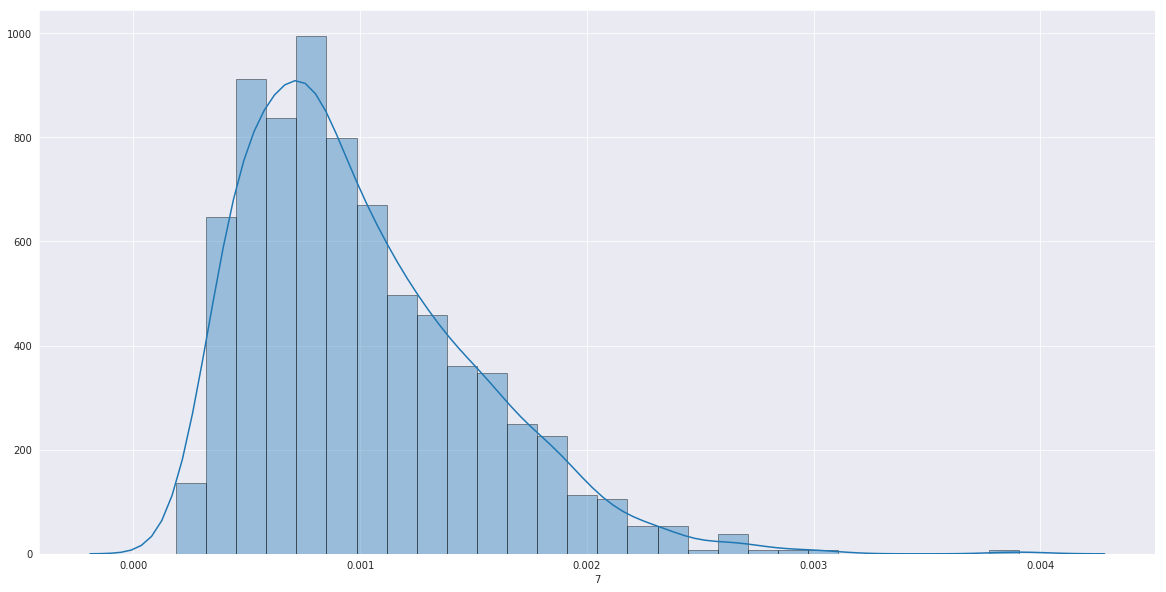

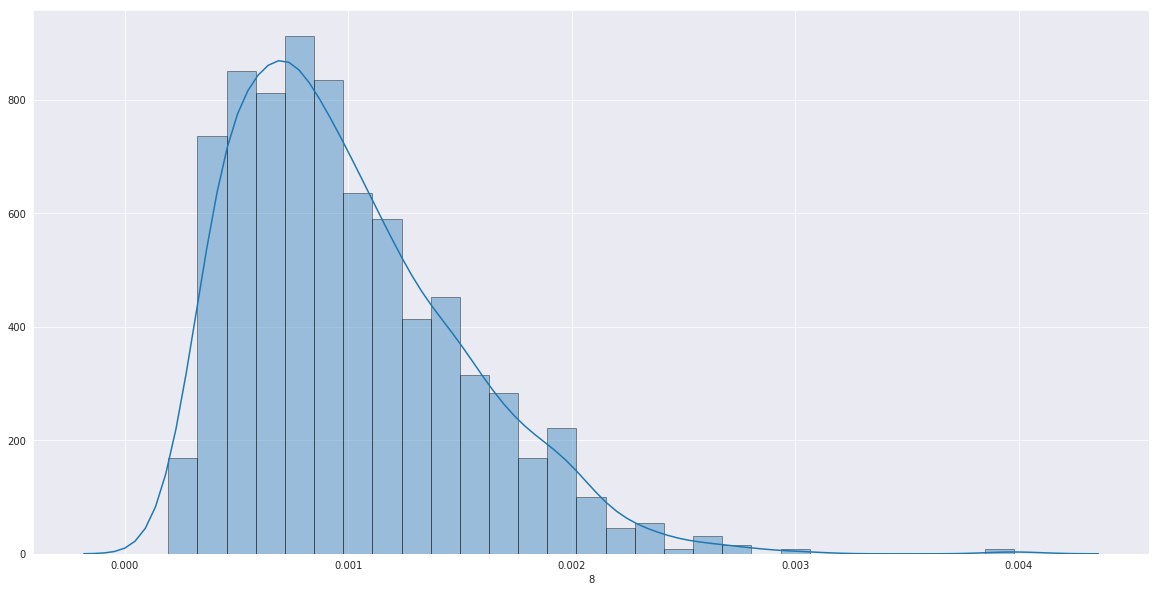

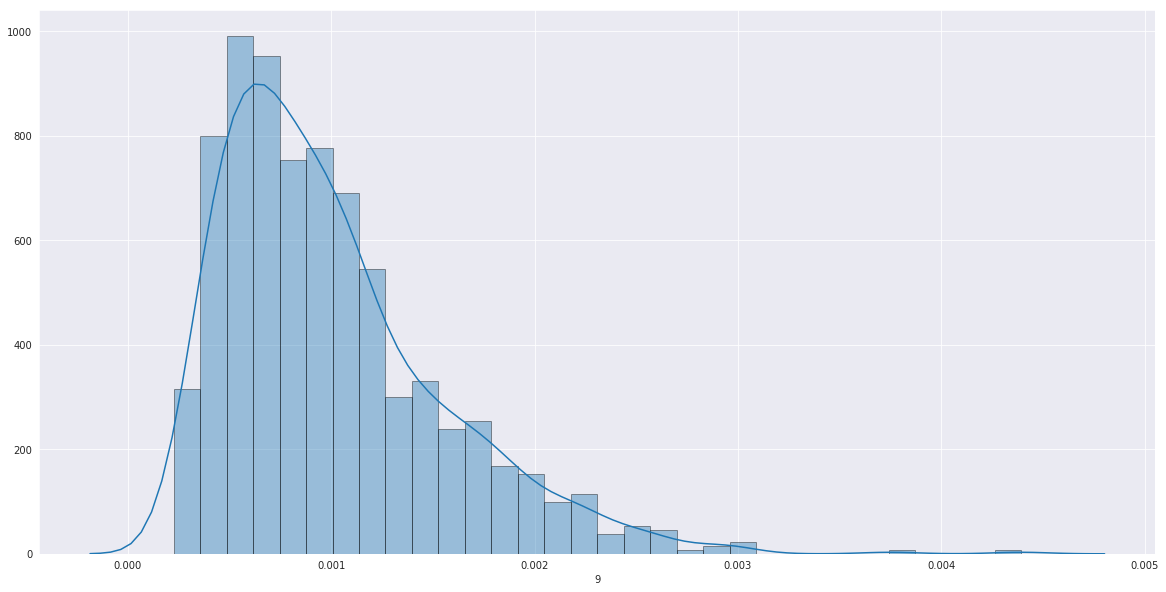

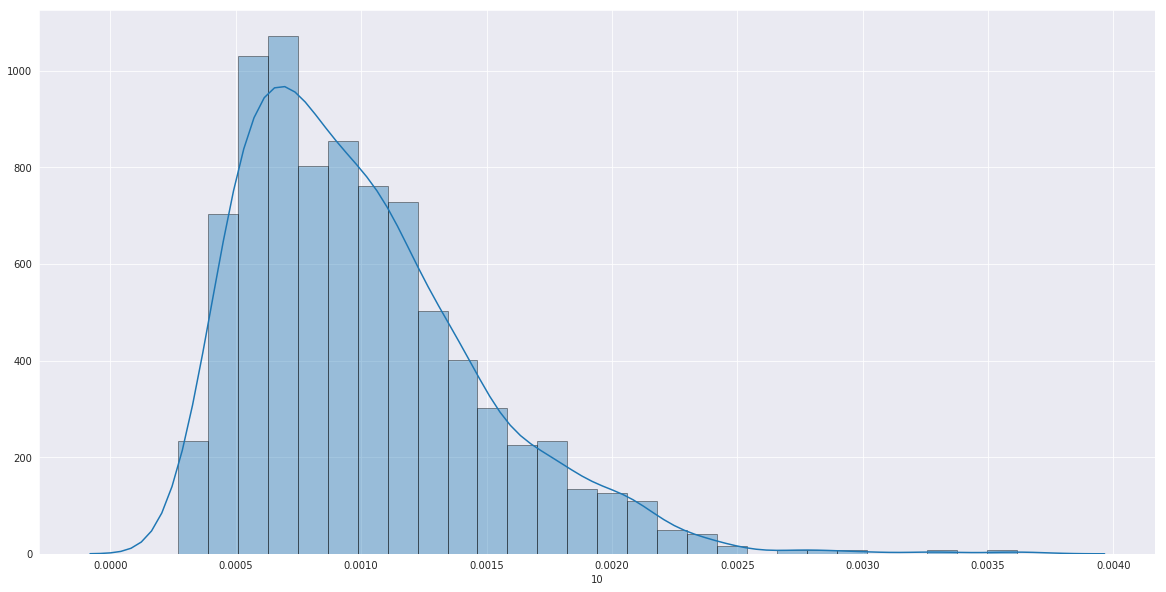

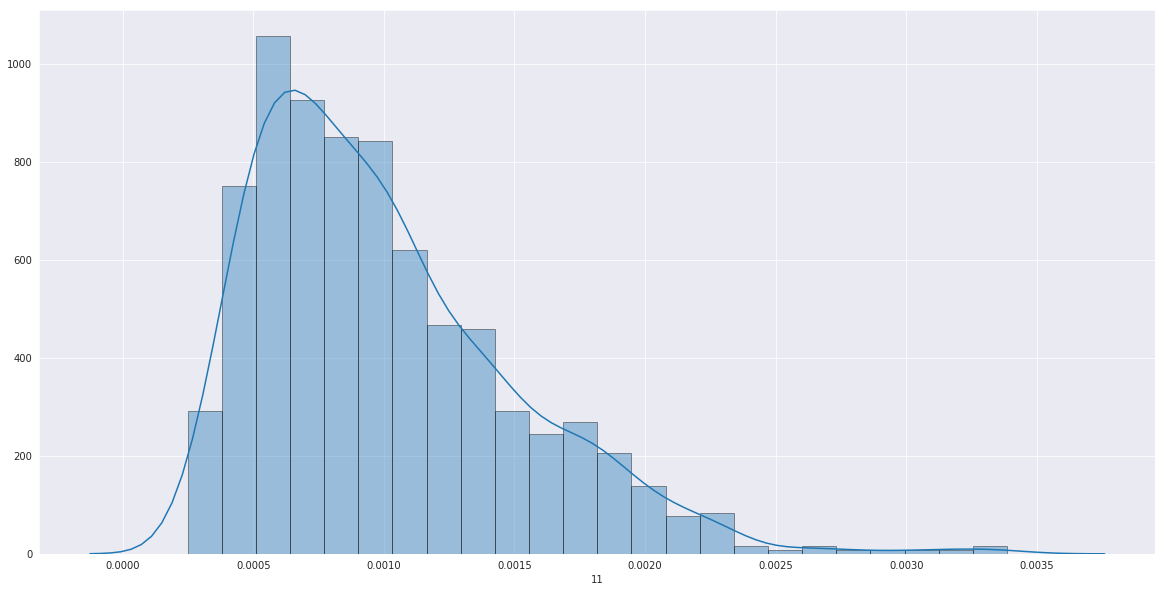

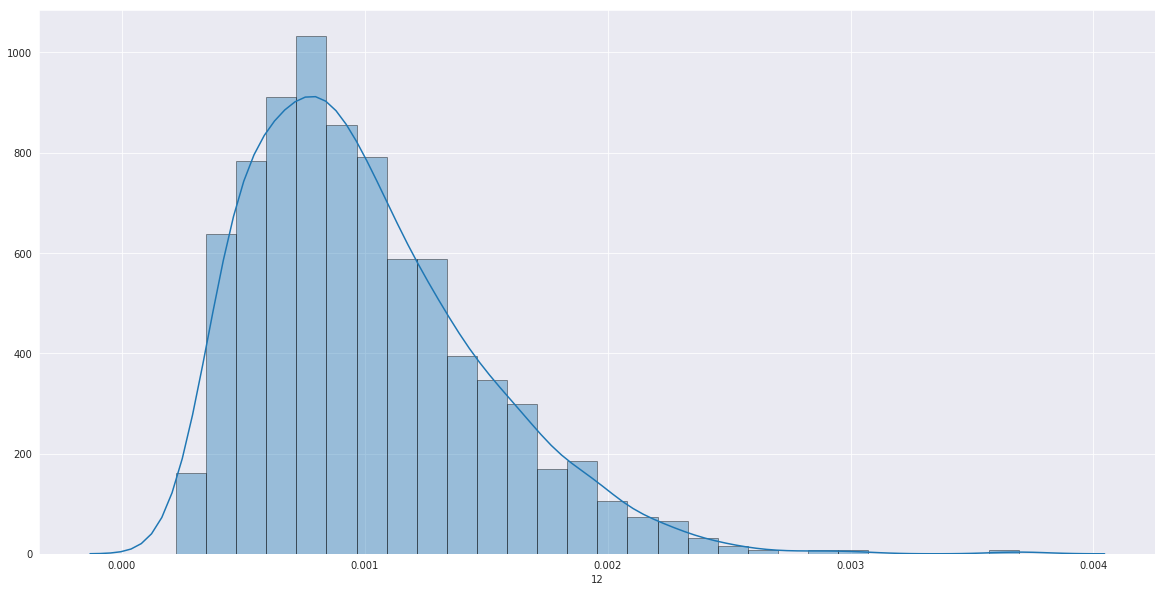

In [21]:
for i in range(0, 325, 25):
    
    labels_ckpt = labels_df.iloc[int(i/(25))]
    
    fig = plt.figure(figsize=(20,10))
    sns.distplot(a = labels_ckpt,
                hist=True,
                kde=True,
                norm_hist=True,
                hist_kws={'edgecolor':'black'})